In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

/home/y_rebryk/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Dataset

In [2]:
from collections import Counter

def get_most_frequent_families(metadata, count):
    counter = Counter(metadata["FamilyID"])
    return {family: index for index, (family, count) in enumerate(counter.most_common()[:count])}

In [3]:
class Proteins:
    def __init__(self, metadata, sequences, count):
        self.count = count
        self.metadata = pd.read_table(metadata)
        self.sequences = pd.read_table(sequences)
        self.families = get_most_frequent_families(self.metadata, self.count)
        
    def __iter__(self):
        for index, row in self.sequences.iterrows():
            family_id = self.families.get(self.metadata.iloc[index]["FamilyID"], None)
            
            if family_id is not None:
                yield self._build_sequence(row["Sequences"]), family_id
    
    @staticmethod
    def _build_sequence(seq):
        crop = len(seq) % 3
        return [seq[i:i+3] for i in range(0, len(seq) - crop, 3)]

In [4]:
proteins = Proteins(metadata="data/family_classification_metadata.tab", 
                    sequences="data/family_classification_sequences.tab",
                    count=100)

## Embedding

In [5]:
class Embedding:
    def __init__(self, filename, length):
        self._length = length
        self._embedding = self._read_embedding(filename)
        self.dimension = 100
        
    def __call__(self, sequence):
        embedding = np.zeros((self._length, self.dimension))
        
        for i, word in enumerate(sequence):
            embedding[i] = self._embedding.get(word, self._embedding["<unk>"])
            
        return embedding
    
    @staticmethod
    def _read_embedding(filename):
        data = {}

        with open(filename, "r") as file:
            for line in file.readlines():
                codone, *values = line.strip()[1:-1].split("\t")
                data[codone] = np.array(list(map(lambda x: np.float(x), values)))

        return data

## Sequence Classification Model

In [6]:
from lazy import lazy

class SequenceClassificationModel:
    def __init__(self, params):
        self.params = params
        self._create_placeholders()
        self.prediction
        self.cost
        self.error
        self.optimize
        self._create_summaries()
    
    def _create_placeholders(self):
        with tf.name_scope("data"):
            self.data = tf.placeholder(tf.float32, [None, self.params.seq_length, self.params.embed_length])
            self.target = tf.placeholder(tf.float32, [None, self.params.classes_count])
  
    def _create_summaries(self):
        with tf.name_scope("summaries"):
            tf.summary.scalar("loss", self.cost)
            tf.summary.scalar("error", self.error)
            self.summary = tf.summary.merge_all()
            saver = tf.train.Saver()
            
    @lazy
    def length(self):
        with tf.name_scope("seq_length"):
            used = tf.sign(tf.reduce_max(tf.abs(self.data), reduction_indices=2))
            length = tf.reduce_sum(used, reduction_indices=1)
            length = tf.cast(length, tf.int32)
            
        return length
    
    @lazy
    def prediction(self): 
        with tf.name_scope("recurrent_layer"):
            output, _ = tf.nn.dynamic_rnn(
                self.params.rnn_cell(self.params.rnn_hidden),
                self.data,
                dtype=tf.float32,
                sequence_length=self.length
            )
            
        last = self._last_relevant(output, self.length)

        with tf.name_scope("softmax_layer"):
            num_classes = int(self.target.get_shape()[1])
            weight = tf.Variable(tf.truncated_normal(
                [self.params.rnn_hidden, num_classes], stddev=0.01))
            bias = tf.Variable(tf.constant(0.1, shape=[num_classes]))
            prediction = tf.nn.softmax(tf.matmul(last, weight) + bias)
            
        return prediction
    
    @lazy
    def cost(self):
        cross_entropy = -tf.reduce_sum(self.target * tf.log(self.prediction))
        return cross_entropy
    
    @lazy
    def error(self):
        self.mistakes = tf.not_equal(tf.argmax(self.target, 1), tf.argmax(self.prediction, 1))
        return tf.reduce_mean(tf.cast(self.mistakes, tf.float32))
    
    @lazy
    def optimize(self):
        with tf.name_scope("optimization"):
            gradient = self.params.optimizer.compute_gradients(self.cost)
            
            if self.params.gradient_clipping:
                limit = self.params.gradient_clipping
                gradient = [
                    (tf.clip_by_value(g, -limit, limit), v)
                    if g is not None else (None, v)
                    for g, v in gradient]
            
            optimize = self.params.optimizer.apply_gradients(gradient)
            
        return optimize
    
    @staticmethod
    def _last_relevant(output, length):
        with tf.name_scope("last_relevant"):
            batch_size = tf.shape(output)[0]
            max_length = int(output.get_shape()[1])
            output_size = int(output.get_shape()[2])

            index = tf.range(0, batch_size) * max_length + (length - 1)
            flat = tf.reshape(output, [-1, output_size])
            relevant = tf.gather(flat, index)
            
        return relevant

### Batch preprocessing

In [7]:
def preprocess_batches(samples, length, embedding, count, batch_size):
    for shift in range(0, len(samples), batch_size):
        data = np.zeros((batch_size, length, embedding.dimension))
        target = np.zeros((batch_size, count))
        
        for index in range(batch_size):
            sequence, label = samples[shift + index]
            data[index] = embedding(sequence)
            target[index, label] = 1
    
        yield data, target

In [8]:
samples = list(proteins)
random.shuffle(samples)

In [9]:
max_length = max(len(seq) for seq, _ in samples)
embedding = Embedding("data/protVec_100d_3grams.csv", max_length)

In [10]:
from attrdict import AttrDict

params = AttrDict(
    rnn_cell=tf.contrib.rnn.GRUCell,
    rnn_hidden=100,
    optimizer=tf.train.RMSPropOptimizer(0.002),
    batch_size=32,
    gradient_clipping=100,
    seq_length=max_length,
    embed_length=embedding.dimension,
    classes_count=proteins.count
)

In [11]:
train, test = samples[:80000], samples[80000:92000]

In [30]:
train_batches = preprocess_batches(train, max_length, embedding, proteins.count, params.batch_size)
test_batches = preprocess_batches(test, max_length, embedding, proteins.count, params.batch_size)

In [13]:
tf.reset_default_graph()
model = SequenceClassificationModel(params)

/home/y_rebryk/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


### Setup session

In [19]:
session = tf.Session()
summary_writer = tf.summary.FileWriter("./graphs", session.graph)

saver = tf.train.Saver()

In [20]:
save_dir = "checkpoints/"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
save_path = os.path.join(save_dir, "proteins")

try:
    print("Trying to restore last checkpoint...")
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)
    saver.restore(session, save_path=last_chk_path)
    print("Restored checkpoint from:", last_chk_path)
except:
    print("Failed to restore checkpoint. Initializing variables instead.")
    session.run(tf.global_variables_initializer())

Trying to restore last checkpoint...
Failed to restore checkpoint. Initializing variables instead.


### Train

In [ ]:
PERIOD = 50
SAVE_PERIOD = 250
    
group_error, group_loss = 0, 0

for index, batch in enumerate(train_batches, 1):
    feed = {model.data: batch[0], model.target: batch[1]}
    error, loss, _, summary_str = session.run([model.error, model.cost, model.optimize, model.summary], 
                                              feed_dict=feed)

    group_error += error
    group_loss += loss

    summary_writer.add_summary(summary_str, index)

    if index % PERIOD == 0:
        print("{}: Average error = {:2.1f}% Average loss = {:2.3f}".format(index, 
                                                                           100 * group_error / PERIOD, 
                                                                           group_loss / PERIOD))
        group_error, group_loss = 0, 0

    if index % SAVE_PERIOD == 0:
        saver.save(session,
                   save_path=save_path,
                   global_step=index)

        print("Saved checkpoint")

50: Average error = 97.4% Average loss = 147.221
100: Average error = 96.9% Average loss = 145.584
150: Average error = 95.9% Average loss = 139.469
200: Average error = 94.2% Average loss = 137.874
250: Average error = 92.6% Average loss = 132.635
Saved checkpoint
300: Average error = 91.0% Average loss = 122.520
350: Average error = 89.9% Average loss = 123.845
400: Average error = 85.8% Average loss = 114.034
450: Average error = 84.8% Average loss = 106.104
500: Average error = 79.9% Average loss = 101.160
Saved checkpoint
550: Average error = 78.3% Average loss = 99.033
600: Average error = 76.4% Average loss = 93.737
650: Average error = 72.4% Average loss = 88.544
700: Average error = 71.1% Average loss = 85.268
750: Average error = 68.4% Average loss = 82.680
Saved checkpoint
800: Average error = 66.7% Average loss = 80.450
850: Average error = 64.2% Average loss = 78.021
900: Average error = 61.1% Average loss = 72.721
950: Average error = 58.5% Average loss = 72.741
1000: Ave

### Test

In [31]:
PERIOD = 25

total_error, total_loss = 0, 0
group_error, group_loss = 0, 0

batches = len(test) / params.batch_size

for index, batch in enumerate(test_batches, 1):
    feed = {model.data: batch[0], model.target: batch[1]}
    error, loss = session.run([model.error, model.cost],
                              feed_dict=feed)
    
    group_error += error
    group_loss += loss
    
    if index % PERIOD == 0:
        print("{}: Average error = {:2.1f}% Average loss = {:2.3f}".format(index, 
                                                                           100 * group_error / PERIOD, 
                                                                           group_loss / PERIOD))
        total_error += group_error
        total_loss += group_loss
        group_error, group_loss = 0, 0

total_error /= batches
total_loss /= batches
print("Test error = {:2.1f}% Test loss = {:2.3f}".format(100 * total_error, total_loss))

25: Average error = 26.9% Average loss = 32.391
50: Average error = 23.9% Average loss = 29.965
75: Average error = 24.2% Average loss = 31.610
100: Average error = 21.8% Average loss = 27.713
125: Average error = 22.2% Average loss = 29.948
150: Average error = 22.5% Average loss = 29.085
175: Average error = 22.1% Average loss = 28.507
200: Average error = 22.5% Average loss = 28.258
225: Average error = 25.6% Average loss = 31.784
250: Average error = 23.4% Average loss = 29.660
275: Average error = 21.9% Average loss = 28.388
300: Average error = 22.1% Average loss = 29.712
325: Average error = 24.1% Average loss = 30.906
350: Average error = 21.5% Average loss = 30.016
375: Average error = 25.8% Average loss = 32.304
Test error = 23.4% Test loss = 30.016


In [32]:
session.close()

## XGBoost

In [33]:
def preprocess_data(data, embedding):
    sequences = np.zeros((len(data), embedding.dimension))
    labels = np.zeros((len(data), 1))
    
    for index, (sequence, label) in enumerate(data):
        sequences[index] = np.sum(embedding(sequence), axis=0)
        labels[index] = label
        
    return sequences, labels

In [34]:
X, Y = preprocess_data(samples, embedding)
train_X, test_X = X[:80000], X[80000:92000]
train_Y, test_Y = Y[:80000], Y[80000:92000]

In [35]:
params = {
    "objective": "multi:softmax",
    "eta": 0.1,
    "silent": 1,
    "max_depth": 6,
    "num_class": 100,
    "nthread": 10
}

In [36]:
xgb_train = xgb.DMatrix(train_X, label=train_Y.squeeze())
xgb_test = xgb.DMatrix(test_X, label=test_Y.squeeze())

In [37]:
watchlist = [(xgb_train, "train"), (xgb_test, "test")]
num_round = 5
booster = xgb.train(params, xgb_train, num_round, watchlist)

[0]	train-merror:0.352713	test-merror:0.407833
[1]	train-merror:0.293375	test-merror:0.363583
[2]	train-merror:0.257975	test-merror:0.336833
[3]	train-merror:0.23235	test-merror:0.31725
[4]	train-merror:0.214425	test-merror:0.302667


## TSNE

In [65]:
tsne = TSNE(n_components=2, random_state=17)
indices = np.logical_or(Y == 0, Y == 1).squeeze()
X_embeded = tsne.fit_transform(X[indices])
Y_embeded = Y[indices]

In [66]:
def plot(X, Y):
    plt.scatter(X[:, 0], X[:, 1], c=Y, s=40, cmap=plt.cm.get_cmap("Set1"))
    plt.show()

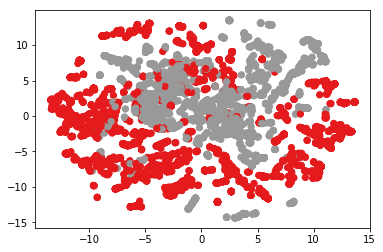

In [67]:
plot(X_embeded, Y_embeded)